In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mplcursors
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util.f_ring import (compute_corrected_ew, 
                                fit_hg_phase_function, 
                                hg_func,
                                print_hg_params,
                                scale_hg_phase_function)

%matplotlib notebook

# Utility Functions

In [19]:
### READ EW STATS AND OBS_LIST RESTRICTIONS

def read_obs_list():
    global OBS_LIST
    OBS_LIST = pd.read_csv('../obs_list.csv', parse_dates=['Date'], index_col='Observation')
    
def read_cassini_ew_stats(filename):
    obsdata = pd.read_csv(filename, parse_dates=['Date'])
    obsdata = obsdata.join(OBS_LIST, on='Observation', rsuffix='_obslist')
    obsdata = obsdata[obsdata['For Photometry'] == 1]
    print(f'** SUMMARY STATISTICS - {filename} **')
    print('Unique observation names:', len(obsdata.groupby('Observation')))
    print('Total slices:', len(obsdata))
    print('Starting date:', obsdata['Date'].min())
    print('Ending date:', obsdata['Date'].max())
    print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
    obsdata['Mu'] = np.abs(np.cos(np.radians(obsdata['Mean Emission'])))
    obsdata['Mu0'] = np.abs(np.cos(np.radians(obsdata['Incidence'])))
    return obsdata

def read_voyager_ew_stats(filename):
    obsdata = pd.read_csv(filename, parse_dates=['Date'])
    print(f'** SUMMARY STATISTICS - {filename} **')
    print('Unique observation names:', len(obsdata.groupby('Observation')))
    print('Total slices:', len(obsdata))
    print('Starting date:', obsdata['Date'].min())
    print('Ending date:', obsdata['Date'].max())
    print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
    obsdata['Mu'] = np.abs(np.cos(np.radians(obsdata['Mean Emission'])))
    obsdata['Mu0'] = np.abs(np.cos(np.radians(obsdata['Incidence'])))
    return obsdata


### CALCULATE QUANTILES


def limit_by_quant(obsdata, cutoff1, cutoff2):
    def xform_func(column):
        if quant2 is None:
            return [(None if z > quant1[column.name] else z) for z in column]
        return [(None if z > quant1[column.name] or
                         z < quant2[column.name] else z) for z in column]
    obsdata = obsdata.copy()
    group = obsdata.groupby('Observation')
    quant1 = group.quantile(cutoff1/100, numeric_only=True)['Normal EW Mean']
    quant2 = None
    if cutoff2 is not None:
        quant2 = group.quantile(cutoff2/100, numeric_only=True)['Normal EW Mean']
    xform = group['Normal EW Mean'].transform(xform_func)
    obsdata['_control'] = xform
    obsdata.dropna(inplace=True)
    return obsdata
    

### SINGLE PLOTS - POINTS

def plot_various_quants(obsdata, include_phase=True):
    """Choose various quantiles of NormalEW and plot w/phase curves."""
    fig, axs = plt.subplots(6, 2, figsize=(10, 12))
    for plot_num, (perc1, perc2, color) in enumerate(((100, None, 'black'),
                                                      ( 90, None, 'black'),
                                                      ( 80, None, 'black'),
                                                      ( 70, None, 'black'),
                                                      ( 60, None, 'black'),
                                                      ( 50, None, 'black'),
                                                      ( 40, None, 'black'),
                                                      ( 30, None, 'black'),
                                                      ( 20, None, 'black'),
                                                      ( 10, None, 'black'),
                                                      ( 80,   20, 'blue'),
                                                      ( 70,   30, 'blue'))):
        ax = axs[plot_num // 2, plot_num % 2]
        quant_obsdata = limit_by_quant(obsdata, perc1, perc2)
        ax.scatter(quant_obsdata['Mean Phase'], quant_obsdata['Normal EW Mean'], marker='o', 
                   s=5, color=color, alpha=1)
        title = f'{perc1} / {perc2}'
        if include_phase:
            params, _, _ = fit_hg_phase_function(2, None, quant_obsdata)
            xrange = np.arange(quant_obsdata['Mean Phase'].min(), quant_obsdata['Mean Phase'].max()+1)
            full_phase_model = hg_func(params, xrange)
            lcolor = 'black' if color != 'black' else 'green'
            total_scale = params[1] + params[3]
            w1 = params[1] / total_scale
            w2 = params[3] / total_scale
            if params[1] < params[3]:
                title  += f' (g1 = {params[2]:6.3f} @ {w2:5.3f} / g2 = {params[0]:6.3f})'
            else:
                title  += f' (g1 = {params[0]:6.3f} @ {w1:5.3f} / g2 = {params[2]:6.3f})'
            ax.plot(xrange, full_phase_model, '-', color=lcolor, lw=3)
            quant_obsdata_mean = quant_obsdata.groupby('Observation').mean(numeric_only=True)
            params_mean, _, _ = fit_hg_phase_function(2, None, quant_obsdata_mean)
            print(f'*** {perc1} / {perc2}: {color}')
            print_hg_params(params)
            print_hg_params(params_mean)
        ax.set_yscale('log')
        ax.set_xlim(0, 180)
        ax.set_xlabel('Phase Angle (°)')
        ax.set_ylabel('Normal EW')
        ax.set_title(title)
    plt.tight_layout()
    
    
### SINGLE PLOTS ON AN AXIS - PHASE CURVE

def _standard_alpha(obsdata):
    """Return alpha based on number of points to plot."""
    if len(obsdata) < 1000:
        return 1
    elif len(obsdata) < 10000:
        return 0.6
    else:
        return 0.3

def _add_hover(obsdata, p):
    """Add hover text to scatter points."""
    cursor = mplcursors.cursor(p, hover=True)
    @cursor.connect('add')
    def on_add(sel):
        row = obsdata.iloc[sel.target.index]
        sel.annotation.set(text=f"{row['Observation']} @ {row['Min Long']:.2f}\n"
                                f"(a={row['Mean Phase']:.0f}, e={row['Mean Emission']:.0f}, "
                                f"i={row['Incidence']:.2f})")
        
def plot_points_phase_curve(obsdata, params, used_obsdata=None, title=None, 
                            col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered used/unused EW points and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    
    if used_obsdata is not None:
        used_obsdata['Phase Model'] = hg_func(params, used_obsdata['Mean Phase'])
        obsdata['_alpha'] = 0.1
        obsdata['_color'] = 'red'
        obsdata.loc[used_obsdata.index, '_alpha'] = 0.3
        obsdata.loc[used_obsdata.index, '_color'] = 'black'
    else:
        obsdata['_alpha'] = 0.3
        obsdata['_color'] = 'black'
        
    p = ax.scatter(obsdata['Mean Phase'], obsdata[col], marker='o', 
                   s=5, color=obsdata['_color'], alpha=obsdata['_alpha'])
    _add_hover(obsdata, p)

    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax.set_yscale('log')
    ax.set_xlim(0, 180)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_heatmap_phase_curve(obsdata, params, title=None, col='Normal EW Mean', ax=None, **kwargs):
    """Plot binned heatmap and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    ymin = obsdata[col].min()
    ymax = obsdata[col].max()
    heatmap, xedges, yedges = np.histogram2d(obsdata['Mean Phase'],
                                             np.log10(obsdata[col]),
                                             bins=(90, 50),
                                             range=[[0,180], [np.log10(ymin), np.log10(ymax)]])
    heatmap = heatmap ** .25
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T[::-1,:], extent=extent, cmap=cm.Greys, interpolation='nearest', aspect='auto')
    
    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, np.log10(full_phase_model), '-', color='green', lw=2)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_points_phase_time(obsdata, params, title=None, time_fit=3, col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered EW points by time with fit time curve colored by phase."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    time0 = np.datetime64('1970-01-01T00:00:00') # epoch
    obsdata['Date_secs'] = (obsdata['Date']-time0).dt.total_seconds()/86400
    obsdata['Phase Curve Ratio'] = obsdata[col] / obsdata['Phase Model']
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata['Date'], obsdata['Phase Curve Ratio'], marker='o', s=5,
                   c=obsdata['Mean Phase'], cmap=cm.jet, alpha=alpha)
    _add_hover(obsdata, p)

    timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], time_fit)
    timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
    timefit = np.polyval(timecoeff, timerange)
    ax.plot(timerange, timefit, '-', lw=2, color='green')
    ax.set_yscale('log')
    ax.set_xlabel('Date of Observation')
    ax.set_ylabel(f'{col} / Full Phase Model')
    if title is not None:
        plt.title(title)

def plot_points_cassini_voyager(c_obsdata, v1_obsdata, v2_obsdata, params=None,
                                title=None, col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered EW points for Cassini, V1, and V2."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    ax.scatter(c_obsdata['Mean Phase'], c_obsdata[col], marker='o', 
               s=5, color='black', alpha=0.3)
    p = ax.scatter(v1_obsdata['Mean Phase'], v1_obsdata[col], marker='^', 
                   s=5, color='red', alpha=1)
    _add_hover(v1_obsdata, p)
    p = ax.scatter(v2_obsdata['Mean Phase'], v2_obsdata[col], marker='^', 
                   s=5, color='green', alpha=1)
    _add_hover(v2_obsdata, p)
    if params is not None:
        scale_c = scale_hg_phase_function(params, c_obsdata)
        scale_v1 = scale_hg_phase_function(params, v1_obsdata)
        scale_v2 = scale_hg_phase_function(params, v2_obsdata)
        print(f'Scale Cassini:   {scale_c:.3f}')
        print(f'Scale Voyager 1: {scale_v1:.3f}')
        print(f'Scale Voyager 2: {scale_v2:.3f}')
        print(f'Cassini/V1: {scale_c/scale_v1:.3f}')
        print(f'Cassini/V2: {scale_c/scale_v2:.3f}')
        xrange = np.arange(c_obsdata['Mean Phase'].min(), c_obsdata['Mean Phase'].max()+1)
        phase_model = hg_func(params, xrange)
        ax.plot(xrange, phase_model*scale_c, '-', color='grey', lw=2)
        ax.plot(xrange, phase_model*scale_v1, '-', color='red', lw=2)
        ax.plot(xrange, phase_model*scale_v2, '-', color='green', lw=2)
        
    ax.set_yscale('log')
    ax.set_xlim(0, 180)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)
    
    
### SINGLE PLOTS ON AN AXIS - RATIOS

def plot_ratio_vs(obsdata, params, vs, color_by, order, ax=None):
    """Plot scattered used/unused EW points vs. another parameter."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    obsdata['Phase Curve Ratio'] = obsdata['Normal EW Mean'] / obsdata['Phase Model']
    
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata[vs], obsdata['Phase Curve Ratio'], marker='o', 
                   s=5, c=obsdata[color_by], cmap=cm.jet, alpha=alpha)
    _add_hover(obsdata, p)

    coeff = np.polyfit(obsdata[vs], obsdata['Phase Curve Ratio'], order)
    xrange = np.linspace(obsdata[vs].min(), obsdata[vs].max(), 100, endpoint=True)
    fit = np.polyval(coeff, xrange)
    ax.plot(xrange, fit, '-', lw=2, color='green')

    ax.set_yscale('log')
    ax.set_xlabel(vs)
    ax.set_ylabel('Normal EW / Full Phase Model')

    
### COMBINED PLOTS
    
def plot_points_phase_curve_time(obsdata, params, title, used_obsdata=None, time_fit=3, **kwargs):
    """Plot 1) scatter+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_points_phase_curve(obsdata, params, used_obsdata=used_obsdata, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()
    
def plot_heatmap_phase_curve_time(obsdata, params, title, time_fit=3, **kwargs):
    """Plot 1) heatmap+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_heatmap_phase_curve(obsdata, params, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()
    
def plot_ratio_vs_mu_mu0(obsdata, params, title, color_by='Mean Phase', order=3):
    """Plot 1) NEW/Model vs Mu 2) NEW/Model vs Mu0."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_ratio_vs(obsdata, params, vs='Mu', color_by=color_by, order=order, ax=axs[0])
    plot_ratio_vs(obsdata, params, vs='Mu0', color_by=color_by, order=order, ax=axs[1])
    plt.suptitle(title)
    plt.tight_layout()


In [30]:
read_obs_list()
obsdata_60_0 = read_cassini_ew_stats('../data_files/cass_ew_60_0.csv')
print()
obsdata_0_1 = read_cassini_ew_stats('../data_files/cass_ew_0_1.csv')
obsdata_0_1_mean = obsdata_0_1.groupby('Observation').mean(numeric_only=True)

** SUMMARY STATISTICS - ../data_files/cass_ew_60_0.csv **
Unique observation names: 155
Total slices: 155
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39

** SUMMARY STATISTICS - ../data_files/cass_ew_0_1.csv **
Unique observation names: 210
Total slices: 38467
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 21:51:55
Time span: 4827 days 02:36:27


# Phase Curves for Various Quantiles

<IPython.core.display.Javascript object>


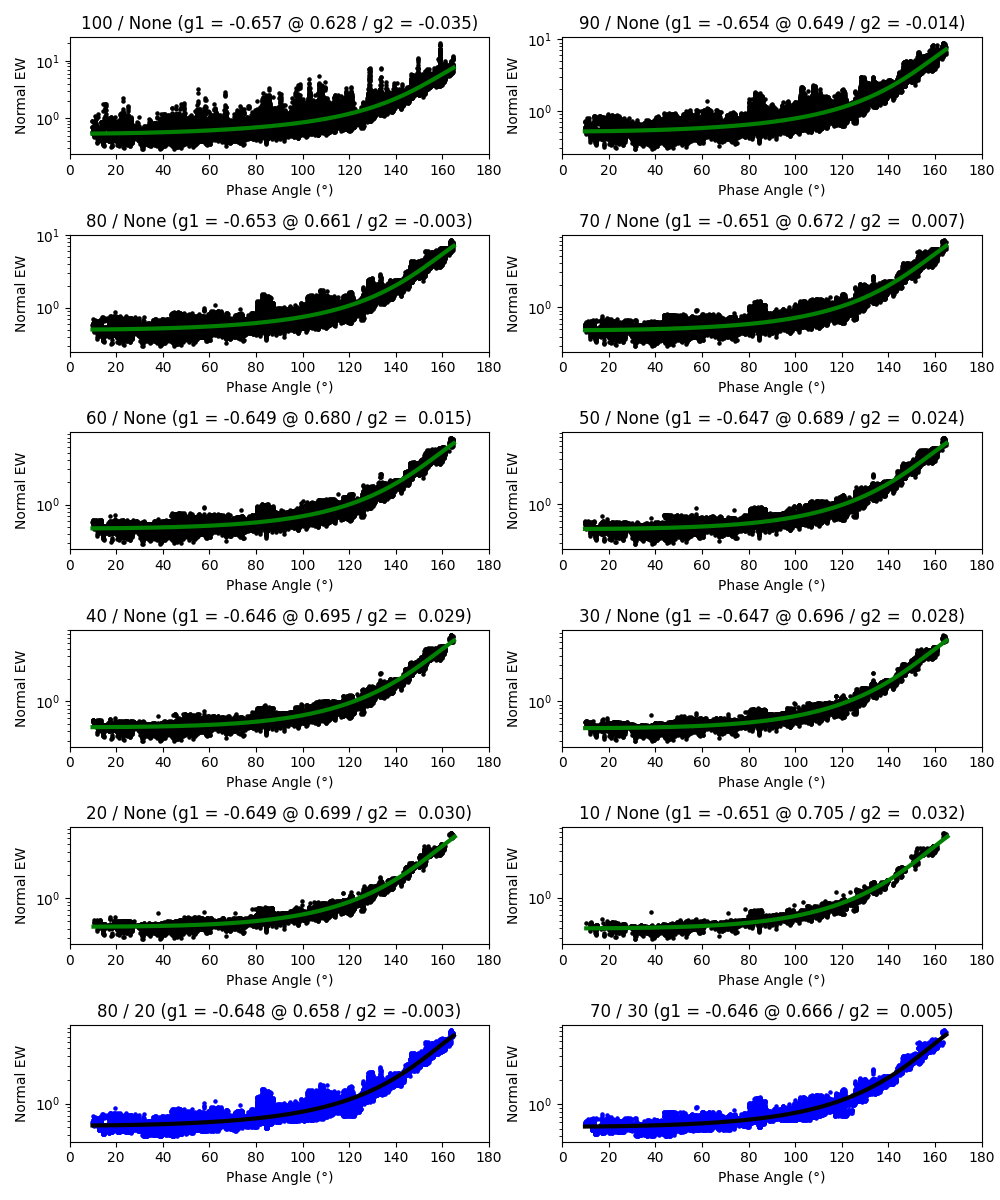

*** 100 / None: black
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372
g1 = -0.684 / scale1 =  1.603 / weight1 = 0.607
g2 = -0.048 / scale2 =  1.040 / weight2 = 0.393
*** 90 / None: black
g1 = -0.654 / scale1 =  1.598 / weight1 = 0.649
g2 = -0.014 / scale2 =  0.863 / weight2 = 0.351
g1 = -0.678 / scale1 =  1.572 / weight1 = 0.627
g2 = -0.034 / scale2 =  0.936 / weight2 = 0.373
*** 80 / None: black
g1 = -0.653 / scale1 =  1.573 / weight1 = 0.661
g2 = -0.003 / scale2 =  0.806 / weight2 = 0.339
g1 = -0.678 / scale1 =  1.549 / weight1 = 0.636
g2 = -0.028 / scale2 =  0.887 / weight2 = 0.364
*** 70 / None: black
g1 = -0.651 / scale1 =  1.554 / weight1 = 0.672
g2 =  0.007 / scale2 =  0.758 / weight2 = 0.328
g1 = -0.675 / scale1 =  1.537 / weight1 = 0.647
g2 = -0.020 / scale2 =  0.840 / weight2 = 0.353
*** 60 / None: black
g1 = -0.649 / scale1 =  1.533 / weight1 = 0.680
g2 =  0.015 / scale2 =  0.721 / weight2 = 0.320
g1 = -0.673 / scale1 =  1.522 

In [31]:
plot_various_quants(obsdata_0_1)

# Check Need for Mu or Mu0 Adjustment

In [5]:
cutoff = 50
obsdata_limited = limit_by_quant(obsdata_60_0, cutoff, None)
params_limited, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
print(f'1 degree slices, {cutoff}% cutoff')
print_hg_params(params_limited)

1 degree slices, 50% cutoff
g1 = -0.653 / scale1 =  1.669 / weight1 = 0.643
g2 = -0.026 / scale2 =  0.927 / weight2 = 0.357


<IPython.core.display.Javascript object>


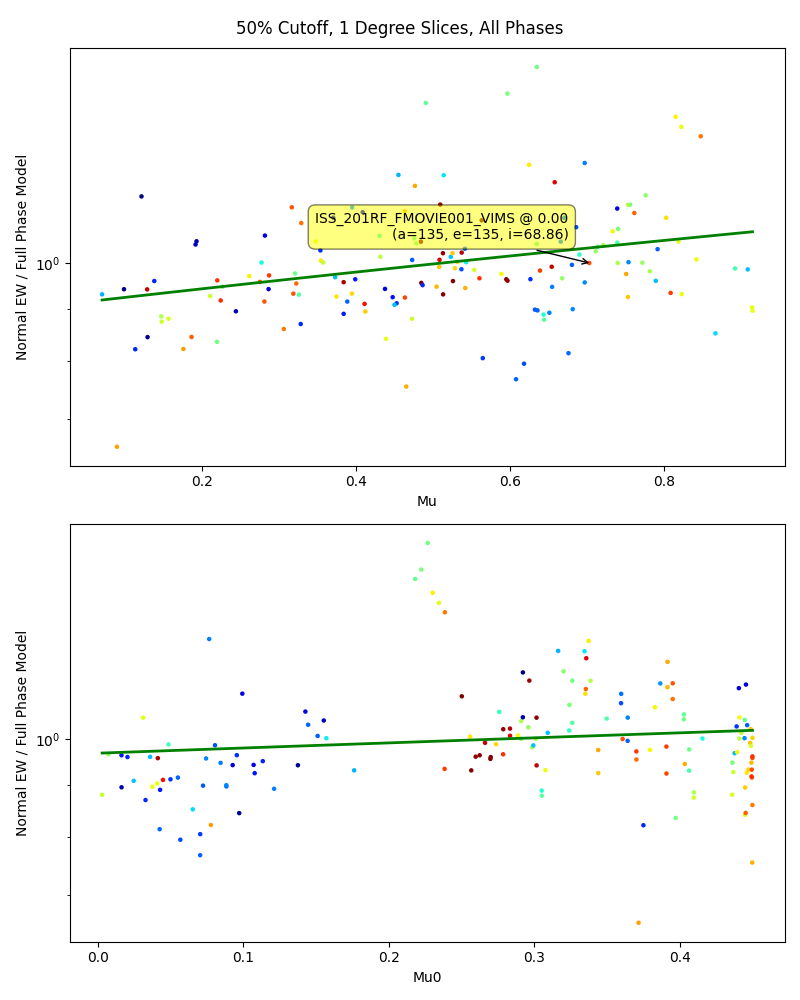

In [6]:
plot_ratio_vs_mu_mu0(obsdata_limited, params_limited, 
                     f'{cutoff}% Cutoff, 1 Degree Slices, All Phases', order=1)

<IPython.core.display.Javascript object>


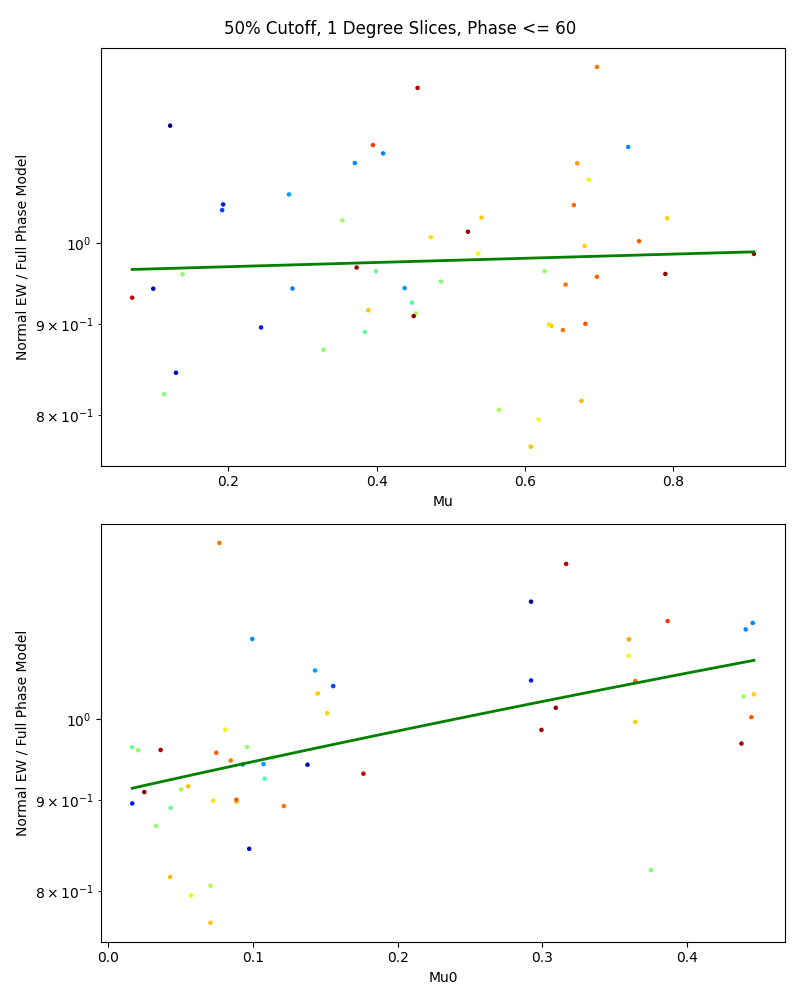

In [7]:
obsdata_limited_low_phase = obsdata_limited[obsdata_limited['Mean Phase'] <= 60].copy()
# obsdata_0_1_low_ei = obsdata_0_1_low_phase[((obsdata_0_1_low_phase['Mean Emission']-90).abs() <= 6) |
#                                             (obsdata_0_1_low_phase['Incidence'] >= 84)].copy()
plot_ratio_vs_mu_mu0(obsdata_limited_low_phase, params_limited, 
                     f'{cutoff}% Cutoff, 1 Degree Slices, Phase <= 60', order=1)

# Check for Time Variation

<IPython.core.display.Javascript object>


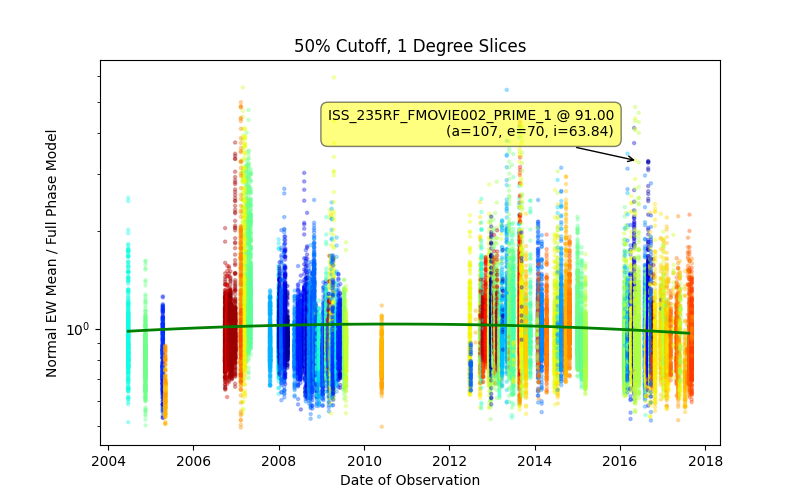

In [8]:
plot_points_phase_time(obsdata_0_1, params_limited, title='50% Cutoff, 1 Degree Slices', time_fit=2)

# Compare Cassini and Voyager

In [28]:
v1_obsdata_60_0 = read_voyager_ew_stats('../data_files/v1_ew_60_0.csv')
v1_obsdata_60_0["Normal EW Mean"] *= 3.345
print()
v1_obsdata_0_1 = read_voyager_ew_stats('../data_files/v1_ew_0_1.csv')
v1_obsdata_0_1["Normal EW Mean"] *= 3.345
print()
v2_obsdata_60_0 = read_voyager_ew_stats('../data_files/v2_ew_60_0.csv')
print()
v2_obsdata_0_1 = read_voyager_ew_stats('../data_files/v2_ew_0_1.csv')

** SUMMARY STATISTICS - ../data_files/v1_ew_60_0.csv **
Unique observation names: 6
Total slices: 6
Starting date: 1980-11-08 01:13:49
Ending date: 1980-11-16 06:09:17
Time span: 8 days 04:55:28

** SUMMARY STATISTICS - ../data_files/v1_ew_0_1.csv **
Unique observation names: 8
Total slices: 752
Starting date: 1980-11-08 01:13:49
Ending date: 1980-11-17 05:04:13
Time span: 9 days 03:50:24

** SUMMARY STATISTICS - ../data_files/v2_ew_60_0.csv **
Unique observation names: 0
Total slices: 0
Starting date: nan
Ending date: nan
Time span: nan

** SUMMARY STATISTICS - ../data_files/v2_ew_0_1.csv **
Unique observation names: 7
Total slices: 172
Starting date: 1981-08-25 14:27:24
Ending date: 1981-08-29 13:08:28
Time span: 3 days 22:41:04


<IPython.core.display.Javascript object>


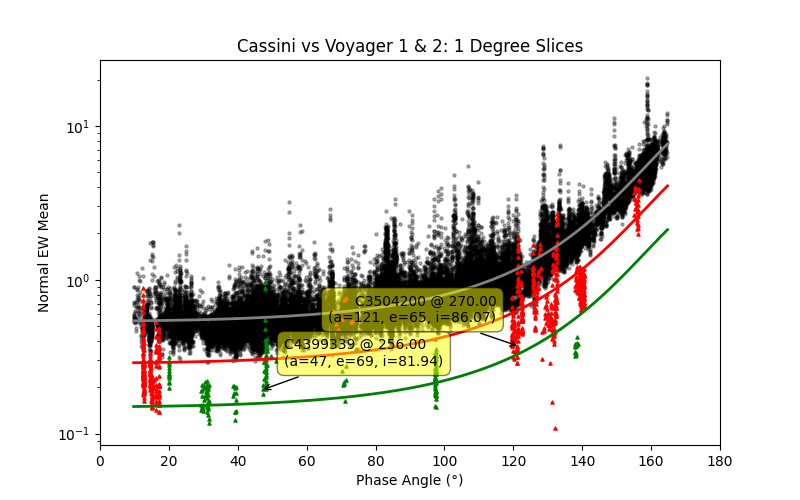

[1.] 0.14620159355335607
[1.00000001] 0.14620157677776563
[1.10722067] 0.025493548942194535
[1.10722069] 0.025493530367914144
[1.10851325] 0.024038377740977453
[1.10851326] 0.024038359145013163
[1.10851343] 0.02403816621542564
[1.10851345] 0.024038147619458352
[1.] -0.529803545369139
[1.00000001] -0.5298035639470141
[0.71005697] -0.16831994504203657
[0.71005699] -0.16831996361991178
[0.60858218] -0.041807249734797554
[0.60858219] -0.04180726831267275
[0.59211999] -0.02128317660857969
[0.59212] -0.0212831951864549
[0.59166266] -0.020713004755101468
[0.59166267] -0.02071302333297666
[0.5916623] -0.020712563980554526
[0.59166232] -0.020712582558429726
[1.] -0.4261319462623984
[1.00000001] -0.42613195640530827
[0.59069007] -0.14752320508058855
[0.59069008] -0.14752321522349848
[0.39907199] -0.0170927732356005
[0.39907201] -0.01709278337851039
[0.32430301] 0.03380091190041143
[0.32430303] 0.03380090175750154
[0.30793486] 0.044942375080549365
[0.30793487] 0.044942364937639485
[0.30706726] 0.

In [29]:
cutoff = 70
obsdata_limited = limit_by_quant(obsdata_0_1, cutoff, None)
params_master, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
plot_points_cassini_voyager(obsdata_0_1, v1_obsdata_0_1, v2_obsdata_0_1, params_master,
                            title='Cassini vs Voyager 1 & 2: 1 Degree Slices')

<IPython.core.display.Javascript object>


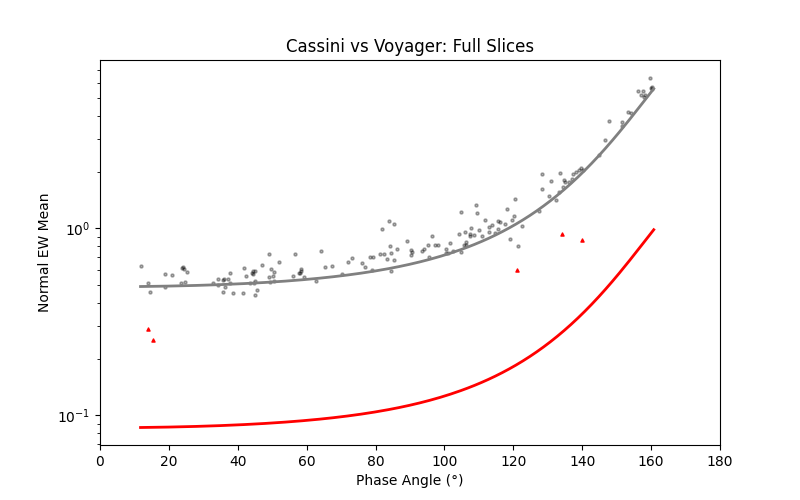

[1.] 0.13711217222612285
[1.00000001] 0.13711215548638234
[1.10691916] 0.01700079500644788
[1.10691918] 0.017000776476908543
[1.10820444] 0.015556936223138682
[1.10820445] 0.015556917672084019
[1.10820462] 0.015556727607497068
[1.10820464] 0.015556709056439397
[1.] -0.5315748395096833
[1.00000001] -0.5315748561932321
[0.67123605] -0.16348611184032635
[0.67123606] -0.16348612852387515
[0.54136604] -0.01808183464375972
[0.54136605] -0.018081851327308506
[0.51190647] 0.014901506790601083
[0.51190649] 0.014901490107052318
[0.51021671] 0.016793390586315748
[0.51021673] 0.01679337390276698
[0.51021111] 0.016799656164195587
[0.51021113] 0.016799639480646816
Scale Cassini:   1.000
Scale Voyager 1: 0.176


In [11]:
plot_points_cassini_voyager(obsdata_60_0, v1_obsdata_60_0, v2_obsdata_60_0, params_master,
                            title='Cassini vs Voyager: Full Slices')

In [12]:
v1_obsdata_0_1[['Observation', 'EW Mean']]

,Observation,EW Mean
0,C3479550,0.594386
1,C3479550,0.566513
2,C3479550,0.636583
3,C3479550,0.621950
4,C3479550,0.596329
...,...,...
630,C3504200,0.238831
631,C3504200,0.294418
632,C3504200,0.330096
633,C3504200,0.278882


In [13]:
v1_obsdata_0_1

,Observation,Slice#,Num Data,Date,Min Long,Max Long,Mean Long,Min Inertial Long,Max Inertial Long,Mean Inertial Long,...,Incidence,% Coverage,EW Mean,EW Std,Normal EW Mean,Normal EW Std,EW Median,Normal EW Median,Mu,Mu0
0,C3479550,0,50,1980-11-09 22:55:09,0.0,0.98,0.49,342.047,343.027,342.537,...,86.178714,49.33,0.594386,0.031191,0.227515,0.003578,0.582012,0.066590,0.114430,0.066645
1,C3479550,1,50,1980-11-09 22:55:09,1.0,1.98,1.49,343.047,344.027,343.537,...,86.178714,49.33,0.566513,0.016818,0.216725,0.001925,0.573712,0.065605,0.114368,0.066645
2,C3479550,2,50,1980-11-09 22:55:09,2.0,2.98,2.49,344.047,345.027,344.537,...,86.178714,49.33,0.636583,0.030852,0.243395,0.003517,0.648110,0.074085,0.114305,0.066645
3,C3479550,3,50,1980-11-09 22:55:09,3.0,3.98,3.49,345.047,346.027,345.537,...,86.178714,49.33,0.621950,0.062320,0.237675,0.007130,0.609894,0.069676,0.114242,0.066645
4,C3479550,4,50,1980-11-09 22:55:09,4.0,4.98,4.49,346.047,347.027,346.537,...,86.178714,49.33,0.596329,0.023238,0.227755,0.002644,0.597835,0.068261,0.114180,0.066645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,C3504200,336,50,1980-11-16 08:57:49,336.0,336.98,336.49,93.016,93.996,93.506,...,86.070149,33.38,0.238831,0.039757,0.340144,0.016929,0.232539,0.099005,0.425770,0.068535
631,C3504200,337,50,1980-11-16 08:57:49,337.0,337.98,337.49,94.016,94.996,94.506,...,86.070149,33.38,0.294418,0.027790,0.419353,0.011834,0.294047,0.125209,0.425813,0.068535
632,C3504200,338,50,1980-11-16 08:57:49,338.0,338.98,338.49,95.016,95.996,95.506,...,86.070149,33.38,0.330096,0.025161,0.470213,0.010714,0.331723,0.141260,0.425853,0.068535
633,C3504200,339,44,1980-11-16 08:57:49,339.0,339.86,339.43,96.016,96.876,96.446,...,86.070149,33.38,0.278882,0.018713,0.397292,0.007969,0.278166,0.118468,0.425886,0.068535
